In [1]:
import os
import re
import glob
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as sk_io
from skimage.transform import resize
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from cvutils.mrcnn.session import init_keras_session
from cvutils import visualize
from celldom import seed
import keras
from keras.preprocessing import image
import wandb
from wandb.keras import WandbCallback

init_keras_session()

#DATA_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'dataset03', 'DigitTraining', 'single')
DATA_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'dataset', 'training', 'digit', 'r0.6', 'validated', 'single')
MODEL_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.6', 'digit_model')
MODEL_PATH = osp.join(MODEL_DIR, 'single_digit_model.h5')

DATA_DIR, MODEL_DIR

Using TensorFlow backend.


('/lab/data/celldom/dataset/training/digit/r0.6/validated/single',
 '/lab/data/celldom/model/r0.6/digit_model')

In [2]:
!ls $DATA_DIR | head -n 1

BF_ST_000_APT_000Day0-APT-0-0.jpeg
ls: write error: Broken pipe


In [3]:
def get_actual_digit(file):
    return osp.basename(file).replace('.jpeg', '').split('-')[-1]

def load_images():
    res = []
    for f in glob.glob(osp.join(DATA_DIR, '*.jpeg')):
        digit = get_actual_digit(f)
        img = sk_io.imread(osp.join(DATA_DIR, f))
        res.append((digit, img))
    res = pd.DataFrame(res, columns=['digit', 'img'])
    res['digit'] = res['digit'].astype(int)
    return res

In [4]:
df = load_images()

In [5]:
# r0.2 num files = 2372, r0.6 = 3219
len(df)

3219

In [6]:
df['digit'].value_counts()

0    1488
1     526
2     185
4     180
3     174
5     155
6     133
8     132
7     124
9     122
Name: digit, dtype: int64

In [7]:
dtypes = df['img'].apply(lambda v: v.dtype)
assert np.all(dtypes == np.uint8)
dtypes.value_counts()

uint8    3219
Name: img, dtype: int64

In [8]:
pd.DataFrame([r['img'].shape for _, r in df.iterrows()]).describe()

,0,1
count,3219.000000,3219.000000
mean,53.485865,38.492078
std,4.015434,5.141459
min,22.000000,19.000000
25%,53.000000,35.000000
50%,55.000000,41.000000
75%,56.000000,42.000000
max,58.000000,46.000000


In [9]:
from sklearn.model_selection import train_test_split
idx = np.arange(len(df))

# Vary test_size (starting large) to get a sense of accuracy with a bigger sample and then decrease for final model
idx_train, idx_test = train_test_split(idx, test_size=.1, random_state=seed, stratify=df['digit'])
df_train, df_test = df.iloc[idx_train], df.iloc[idx_test]

len(df_train), len(df_test)

(2897, 322)

In [10]:
pd.concat([df_train['digit'].value_counts(normalize=True), df_test['digit'].value_counts(normalize=True)], axis=1)

,digit,digit
0,0.462202,0.462733
1,0.163272,0.164596
2,0.057301,0.059006
3,0.054194,0.052795
4,0.055920,0.055901
5,0.047981,0.049689
6,0.041422,0.040373
7,0.038661,0.037267
8,0.041077,0.040373
9,0.037970,0.037267


## Training

In [11]:
%run utils.py

In [12]:
target_shape = (32, 32)

In [13]:
from imgaug import augmenters as iaa
from skimage import img_as_ubyte, img_as_float32

sometimes = lambda aug: iaa.Sometimes(.3, aug)
seq = iaa.Sequential([
    # Simulate out-of-focus
    sometimes(iaa.GaussianBlur(sigma=1.0)),
    
    # Randomly alter scaling and simulate zooming
    sometimes(iaa.Crop(px=(0, 10))),
    
    # Rotate up to 3 degrees and randomly scale
    sometimes(iaa.Affine(rotate=3., scale={"x": (.8, 1.4), "y": (.8, 1.4)}, mode='reflect')),
    
    
    # Randomly alter distribution
    sometimes(iaa.OneOf([
        iaa.Multiply((.8, 1.4)), 
        iaa.Add((-25, 25)),
        iaa.ContrastNormalization((0.8, 1.2))
    ]))
], random_order=True)

def augment(img):
    # img should be provided as float in [0, 1]
    assert img.min() >= 0 and img.max() <= 1.
    img = rescale_intensity(img, out_range=np.uint8).astype(np.uint8)
    res = img_as_float32(seq.augment_image(img))
    #print(res.shape, res.dtype, res.min(), res.max())
    return res

In [14]:
def prep_image(img):
    # Note that gray2rgb will take care of converting from uint8 to float in 0-1
    assert img.dtype == np.uint8
    img = gray2rgb(resize(img, target_shape, mode='constant', anti_aliasing=True)).astype(np.float32)
    assert np.all(img <= 1.) and np.all(img >= 0.)
    return img

train_x = np.stack([prep_image(v) for v in df_train['img']], 0)
train_y = keras.utils.to_categorical(df_train['digit'].values, 10)

test_x = np.stack([prep_image(v) for v in df_test['img']], 0)
test_y = keras.utils.to_categorical(df_test['digit'].values, 10)

train_generator = image.ImageDataGenerator(preprocessing_function=augment)
train_batches = train_generator.flow(train_x, y=train_y, seed=seed)

test_generator = image.ImageDataGenerator()
test_batches = test_generator.flow(test_x, y=test_y, seed=seed)

train_x.dtype, train_x.shape, test_x.shape

(dtype('float32'), (2897, 32, 32, 3), (322, 32, 32, 3))

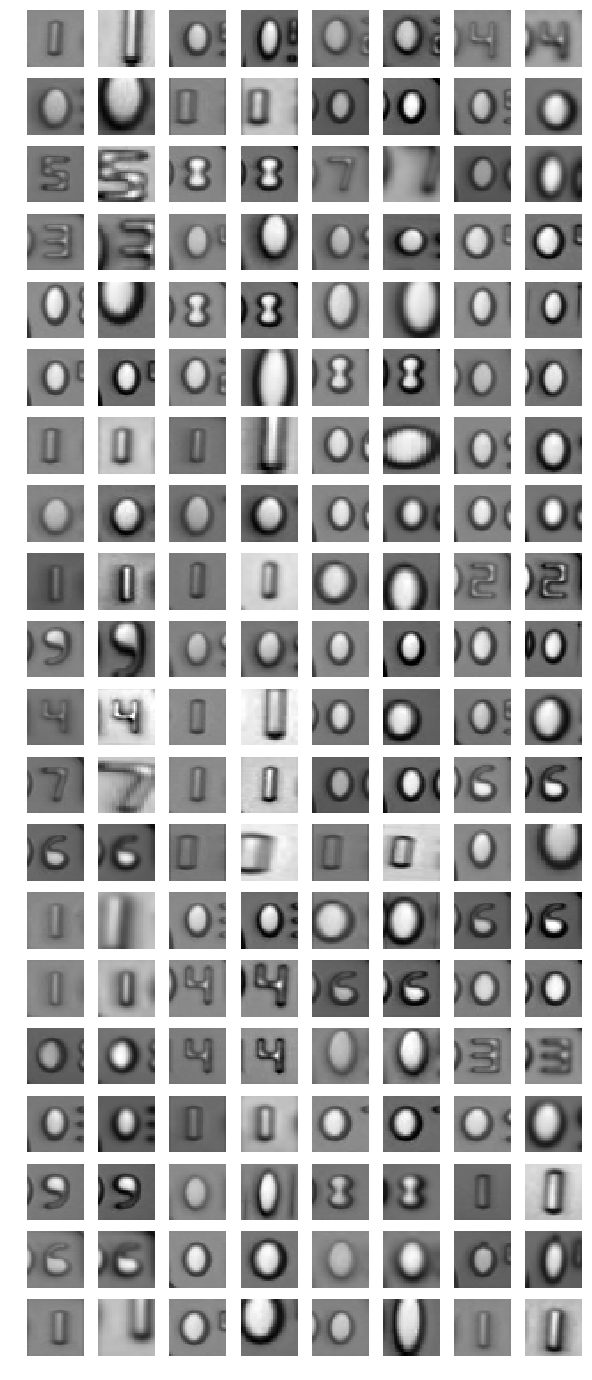

In [15]:
# Visualize augmentations
aug_imgs = []
for img in df_train['img'].sample(n=80):
    aug_imgs.append(prep_image(img))
    aug_imgs.append(augment(prep_image(img)))
visualize.display_images(aug_imgs, cols=8, size=10)

### Initialize Modeling

In [16]:
MODEL_DIR

'/lab/data/celldom/model/r0.6/digit_model'

In [17]:
!ls $MODEL_DIR

events.out.tfevents.1536775121.18201d6b5c9f  single_digit_model.h5


In [18]:
# Clear everything currently in the modeling directory
!rm -rf $MODEL_DIR/*

In [19]:
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/jbfj35w1
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/jbfj35w1

### Run Training

In [20]:
MODEL_DIR

'/lab/data/celldom/model/r0.6/digit_model'

In [21]:
if not osp.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [22]:
!ls $MODEL_DIR

In [23]:
model = get_digit_model(input_shape=target_shape + (3,), mode='tune')
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.001),
    metrics=['accuracy']
)

# Initialize from pre-trained model
model.load_weights('/lab/repos/svhn/weights.hdf5')

In [24]:
save_model = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_acc', mode='max', verbose=0,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='max')
tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR)
callbacks = [save_model, early_stopping, tensorboard]

with wandb.monitor(display=False):
    model.fit_generator(
        train_batches, 
        epochs=50,
        callbacks=callbacks + [WandbCallback(save_model=False)],
        validation_data=test_batches
    )

Instructions for updating:
Use the retry module or similar alternatives.
Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/jbfj35w1


Epoch 1/50
91/91 [==============================] - 5s 55ms/step - loss: 0.2414 - acc: 0.9348 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 2/50
91/91 [==============================] - 4s 43ms/step - loss: 0.1044 - acc: 0.9725 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 3/50
91/91 [==============================] - 4s 46ms/step - loss: 0.0755 - acc: 0.9805 - val_loss: 1.1317e-04 - val_acc: 1.0000
Epoch 4/50
91/91 [==============================] - 4s 46ms/step - loss: 0.0655 - acc: 0.9815 - val_loss: 3.8843e-05 - val_acc: 1.0000
Epoch 5/50
91/91 [==============================] - 4s 45ms/step - loss: 0.0507 - acc: 0.9873 - val_loss: 1.0011e-05 - val_acc: 1.0000
Epoch 6/50
91/91 [==============================] - 4s 46ms/step - loss: 0.0464 - acc: 0.9867 - val_loss: 4.1999e-06 - val_acc: 1.0000
Epoch 7/50
91/91 [==============================] - 4s 48ms/step - loss: 0.0466 - acc: 0.9866 - val_loss: 1.9811e-06 - val_acc: 1.0000
Epoch 8/50
91/91 [==============================] - 4s 44ms/ste

## Inference 

In [25]:
model = keras.models.load_model(MODEL_PATH)

In [30]:
#inf_x, inf_y = test_x, test_y
inf_x, inf_y = train_x, train_y
inf_y = np.argmax(inf_y, axis=1)
inf_x.shape, inf_y.shape

((2897, 32, 32, 3), (2897,))

In [31]:
inf_y_pred = model.predict_classes(inf_x)
inf_y_pred.shape

(2897,)

In [32]:
# Overall accuracy
(inf_y_pred == inf_y).mean()

0.9986192613047981

In [33]:
pd.DataFrame(dict(pred=inf_y_pred, true=inf_y)).groupby(['pred', 'true']).size().unstack().fillna(0)\
    .style.background_gradient(high=.7)

true,0,1,2,3,4,5,6,7,8,9
pred,,,,,,,,,,
0,1339,0,0,0,0,0,0,1,0,0
1,0,471,0,0,0,0,0,0,0,0
2,0,0,166,0,0,0,0,0,0,0
3,0,0,0,157,0,0,0,0,0,0
4,0,0,0,0,162,0,0,0,0,0
5,0,0,0,0,0,139,0,1,0,0
6,0,0,0,0,0,0,120,0,0,0
7,0,0,0,0,0,0,0,110,0,0
8,0,2,0,0,0,0,0,0,119,0


#### Show Misclassified Instances (if any)

In [34]:
misclassified = np.argwhere(inf_y_pred != inf_y).ravel()

In [35]:
len(misclassified)

4

In [36]:
misclassified

array([ 478, 1186, 1485, 2457])

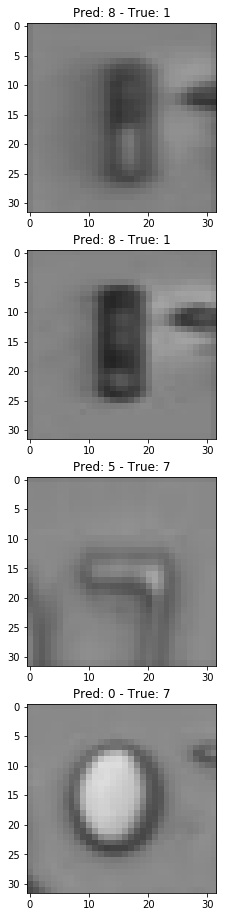

In [37]:
#n_samp = 10
#indexes = pd.Series(list(range(len(pred_y_class)))).sample(n_samp)

n_samp = len(misclassified)
indexes = misclassified

fig, ax = plt.subplots(n_samp, 1)
if n_samp == 1:
    ax = [ax]
fig.set_size_inches(4, n_samp * 4)
for i, idx in enumerate(indexes):
    ax[i].imshow(inf_x[idx])
    ax[i].set_title('Pred: {} - True: {}'.format(inf_y_pred[idx], inf_y[idx]))